### FHVHV Data Pipeline - Stage 3: Demand Forecasting

**Pipeline Position:** Stage 3 of 4

- Stage 0: Data Download (Complete)
- Stage 1: Data Validation (Complete)
- Stage 2: Exploratory Analysis (Complete)
- Stage 3: Modeling ← THIS NOTEBOOK

**Objective:** Build and evaluate models to forecast daily zone demand.

**Target Variable:** `daily_trips` - daily trip count per zone

**Inputs:**
- `data/processed/zone_daily.parquet` - Daily aggregated data (100 zones × 1,096 days)

**Outputs:**
- `data/model_outputs/forecasts.parquet`
- `data/model_outputs/model_comparison.csv`

**Approach:** 
1. Baseline (Seasonal Naive) → sets performance bar
2. Prophet → captures trend + seasonality + holidays
3. XGBoost → uses engineered features

**Strategy:** Develop on pilot zone → Evaluate → Scale to 100 zones

#### 1. Setup

##### 1.1 Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (8, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
    'axes.grid': True,
    'axes.grid.axis': 'y'
})
plt.rcParams['patch.facecolor'] = 'steelblue'

print("Libraries imported successfully")

Libraries imported successfully


##### 1.2 Configure Environment 

**Analysis Scope:**

> **Time Period:**   2022-2024 (3 years, 1,096 days)  
> **Zone Selection:**   Top zones capturing ~80% of total demand  
> **Granularity:**   Daily aggregation by zone

In [2]:
# Define file paths using relative references so notebook works from any machine
INPUT_FILE = Path("../data/validated/fhvhv_valid_data_for_eda.parquet")
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set analysis parameters 
TOP_N_ZONES = 100  # # Target: ~80% demand coverage
MIN_DATE = '2022-01-01'  
MAX_DATE = '2024-12-31'  

print(f"Configuration:")
print(f"  Input: {INPUT_FILE}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Analysis period: {MIN_DATE} to {MAX_DATE}")
print(f"  Target zones: Top {TOP_N_ZONES}")

Configuration:
  Input: ..\data\validated\fhvhv_valid_data_for_eda.parquet
  Output directory: ..\data\processed
  Analysis period: 2022-01-01 to 2024-12-31
  Target zones: Top 100


##### 1.3 Identify Fields to Use in Analysis

**Time Series Target:**

> Daily trip counts by zone with supplementary duration and distance metrics.  

**Fields Used:**
> **pickup_datetime:** Trip timestamp → aggregated to daily index  
> **PULocationID:** Zone identifier (1-263) → renamed to `zone_id`  
> **trip_time:** Duration in seconds → aggregated to daily avg/total minutes  
> **trip_miles:** Distance → aggregated to daily avg/total miles  

See [NYC TLC Data Dictionary](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for complete documentation.  

---

#### 2. Explore Data and Select Zones for Analysis
This section explores the validated dataset structure, confirms the data quality, and selects zones for forecasting. DuckDB will be used to query the 18GB parquet file efficiently without loading into memory.

##### 2.1 Review Dataset Structure

In [3]:
# Initialize DuckDB connection
con = duckdb.connect()

In [4]:
# Query dataset statistics
stats = con.execute(f"""
    SELECT 
        COUNT(*) as row_count,
        COUNT(DISTINCT PULocationID) as unique_zones,
        MIN(pickup_datetime) as min_date,
        MAX(pickup_datetime) as max_date
    FROM '{INPUT_FILE}'
""").fetchone()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
# Query column structure with analysis fields marked
schema = con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df()

analysis_fields = ['pickup_datetime', 'PULocationID', 'trip_time', 'trip_miles']
schema['used_in_analysis'] = schema['column_name'].isin(analysis_fields)
schema = schema.sort_values('used_in_analysis', ascending=False)
schema['used_in_analysis'] = schema['used_in_analysis'].map({True: '✓', False: ''})


In [6]:
# Query company breakdown
companies = con.execute(f"""
    SELECT 
        hvfhs_license_num,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY hvfhs_license_num
    ORDER BY trips DESC
""").df()

total_trips = companies['trips'].sum()


In [7]:
# Display dataset overview
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Rows:         {stats[0]:,}")
print(f"Columns:      {len(schema)}")
print(f"Unique Zones: {stats[1]}")
print(f"Date Range:   {stats[2]} to {stats[3]}")

print(f"\nCOMPANY BREAKDOWN")
print("-" * 50)
total_trips = companies['trips'].sum()
for _, row in companies.iterrows():
    pct = row['trips'] / total_trips * 100
    company = "Uber" if row['hvfhs_license_num'] == "HV0003" else "Lyft"
    print(f"  {row['hvfhs_license_num']} ({company}): {row['trips']:,} trips ({pct:.1f}%)")

print(f"\nCOLUMN STRUCTURE (✓ = used in analysis)")
print("-" * 50)
display(schema)

DATASET OVERVIEW
Rows:         683,780,462
Columns:      24
Unique Zones: 263
Date Range:   2022-01-01 00:00:00 to 2024-12-31 23:59:59

COMPANY BREAKDOWN
--------------------------------------------------
  HV0003 (Uber): 499,553,891 trips (73.1%)
  HV0005 (Lyft): 184,226,571 trips (26.9%)

COLUMN STRUCTURE (✓ = used in analysis)
--------------------------------------------------


,column_name,column_type,null,key,default,extra,used_in_analysis
5,pickup_datetime,TIMESTAMP,YES,None,None,None,✓
7,PULocationID,BIGINT,YES,None,None,None,✓
9,trip_miles,DOUBLE,YES,None,None,None,✓
10,trip_time,BIGINT,YES,None,None,None,✓
0,hvfhs_license_num,VARCHAR,YES,None,None,None,
14,sales_tax,DOUBLE,YES,None,None,None,
22,wav_request_flag,VARCHAR,YES,None,None,None,
21,access_a_ride_flag,VARCHAR,YES,None,None,None,
20,shared_match_flag,VARCHAR,YES,None,None,None,
19,shared_request_flag,VARCHAR,YES,None,None,None,


##### 2.2 Check for Missing Values

In [8]:
# Check for null values in analysis fields
print("\nNULL VALUE CHECK\n" + "-"*40)

null_check = con.execute(f"""
    SELECT 
        SUM(CASE WHEN pickup_datetime IS NULL THEN 1 ELSE 0 END) as null_pickup_datetime,
        SUM(CASE WHEN PULocationID IS NULL THEN 1 ELSE 0 END) as null_zone,
        SUM(CASE WHEN trip_time IS NULL THEN 1 ELSE 0 END) as null_trip_time,
        SUM(CASE WHEN trip_miles IS NULL THEN 1 ELSE 0 END) as null_trip_miles
    FROM '{INPUT_FILE}'
""").df()

print("Null counts in analysis fields:")
for col in null_check.columns:
    count = null_check[col].iloc[0]
    status = "OK" if count == 0 else "FOUND"
    print(f"  {col}: {count:,} ({status})")


NULL VALUE CHECK
----------------------------------------


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Null counts in analysis fields:
  null_pickup_datetime: 0.0 (OK)
  null_zone: 0.0 (OK)
  null_trip_time: 0.0 (OK)
  null_trip_miles: 0.0 (OK)


##### 2.3 Validate Data Completeness
Time series forecasting requires continuous data. This section verifies zones have data for all 36 months. Monthly check identifies major coverage gaps; minor daily gaps can be imputed during feature engineering.

In [9]:
# Identify which zones have complete 36-month time series coverage
print("DATE COMPLETENESS CHECK\n" + "-"*40)

# Query database to count distinct months and total trips per zone
zone_completeness = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(DISTINCT DATE_TRUNC('month', pickup_datetime)) as months_present,
        COUNT(*) as total_trips
    FROM '{INPUT_FILE}'
    GROUP BY PULocationID
    ORDER BY months_present, total_trips DESC
""").df()

# Define expected number of months based on analysis period
expected_months = 36  # 2022-2024 = 3 years

# Split zones into complete (usable) vs incomplete (exclude) based on month count
incomplete_zone_ids = zone_completeness[zone_completeness['months_present'] < expected_months]
complete_zone_ids = zone_completeness[zone_completeness['months_present'] == expected_months]['zone_id'].tolist()

# Print summary statistics and list of incomplete_zone_ids zones
print(f"Expected months: {expected_months}")
print(f"Zones with complete data: {len(complete_zone_ids)}")
print(f"Zones with incomplete data: {len(incomplete_zone_ids)}")

if len(incomplete_zone_ids) > 0:
    print(f"\nIncomplete zones (will not be used in aggregation):")
    print(incomplete_zone_ids.to_string(index=False))

DATE COMPLETENESS CHECK
----------------------------------------


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Expected months: 36
Zones with complete data: 260
Zones with incomplete data: 3

Incomplete zones (will not be used in aggregation):
 zone_id  months_present  total_trips
     264               1            1
       1              25           52
     105              33          126


**Interpretation:** Incomplete zones represent <0.001% of total trips (179 of 683M) - minimal impact on analysis.

##### 2.4 Analyze Zone Trip Volumes
This section examines how rideshare demand is distributed across NYC's 263 taxi zones.

###### 2.4.1 Calculate Trip Volume Totals

In [10]:
# Calculate total trips and percentages by zone to understand demand distribution across all zones
zone_totals = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        COUNT(*) as total_trips
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, complete_zone_ids))})
    GROUP BY PULocationID
    ORDER BY total_trips DESC
""").df()

# Calculate percentage of total
zone_totals['pct_of_total'] = (zone_totals['total_trips'] / zone_totals['total_trips'].sum() * 100).round(2)

print(f"\nZone demand distribution calculated")
print(f"  Total zones: {len(zone_totals)}")
print(f"  Total trips: {zone_totals['total_trips'].sum():,}")
display(zone_totals.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Zone demand distribution calculated
  Total zones: 260
  Total trips: 683,780,283


,zone_id,total_trips,pct_of_total
0,138,12932636,1.89
1,132,12369771,1.81
2,79,9672546,1.41
3,61,8979762,1.31
4,230,8684804,1.27


###### 2.4.2 Visualize Volume Distribution

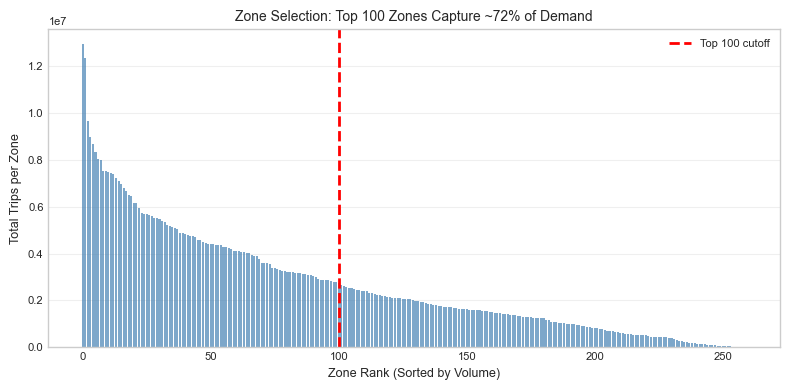

In [11]:
# Visualize zone demand distribution
zone_totals['cumulative_pct'] = zone_totals['pct_of_total'].cumsum()
top_n_pct = zone_totals.iloc[:TOP_N_ZONES]['cumulative_pct'].iloc[-1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.bar(range(len(zone_totals)), zone_totals['total_trips'], 
        color='steelblue', alpha=0.7)
ax1.axvline(x=TOP_N_ZONES, color='red', linestyle='--', linewidth=2,
            label=f'Top {TOP_N_ZONES} cutoff')
ax1.set_xlabel('Zone Rank (Sorted by Volume)')
ax1.set_ylabel('Total Trips per Zone')
ax1.set_title('Zone Selection: Top 100 Zones Capture ~72% of Demand')
ax1.legend(loc='upper right')
ax1.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:** Gradual decline shows demand is distributed across zones, not concentrated in a few hot spots. This justifies selecting 100 zones to capture meaningful coverage (~72% of demand).

###### 2.4.3 Analyze Cumulative Coverage (Pareto)

In [12]:
# Pareto analysis - cumulative coverage by zone count
print("\nPARETO ANALYSIS\n" + "-"*40)
print("Cumulative trip coverage by zone count:\n")

for n in [10, 20, 30, 50, 75, 100, 150]:
    if n <= len(zone_totals):
        pct = zone_totals.iloc[:n]['cumulative_pct'].iloc[-1]
        marker = " <--" if n == TOP_N_ZONES else ""
        print(f"  Top {n:3d} zones: {pct:5.1f}%{marker}")

# Determine concentration pattern
if top_n_pct > 75:
    pattern = "Highly Concentrated"
    explanation = "Few zones dominate - classic Pareto pattern"
elif top_n_pct > 60:
    pattern = "Moderately Concentrated"
    explanation = "Some concentration with meaningful distributed tail"
else:
    pattern = "Distributed"
    explanation = "Demand spread across many zones"



PARETO ANALYSIS
----------------------------------------
Cumulative trip coverage by zone count:

  Top  10 zones:  13.5%
  Top  20 zones:  23.7%
  Top  30 zones:  32.1%
  Top  50 zones:  46.5%
  Top  75 zones:  61.3%
  Top 100 zones:  72.5% <--
  Top 150 zones:  87.8%


**Interpretation:** Demand follows a distributed pattern rather than classic Pareto concentration (80/20 rule). Capturing 72.5% of trips requires 100 zones, compared to the typical Pareto expectation of ~20 zones for 80% coverage. This distribution justifies a broader zone selection strategy - focusing only on the top 10-20 zones would miss the majority of rideshare activity. The selected 100 zones provide substantial coverage while remaining computationally manageable for multi-series forecasting. The remaining 27.5% of trips are spread across 160+ lower-volume zones where forecasting would be less reliable due to sparse data.

##### 2.5 Select Final Zones for Analysis
Select top zones capturing ~80% of total demand and save as a list to use during aggregation.

In [14]:
print(f"\nFINAL ZONE SELECTION\n" + "-"*40)

# Filter zone_totals to only zones with complete 36-month coverage
complete_zone_totals = zone_totals[zone_totals['zone_id'].isin(complete_zone_ids)].copy()
print(f"Zones with complete 36-month coverage: {len(complete_zone_totals)}")

# Select the top N zones by trip volume from complete zones
selected_zones = complete_zone_totals.nlargest(TOP_N_ZONES, 'total_trips').reset_index(drop=True)
print(f"Selected for analysis: {len(selected_zones)}")

# Verify the expected number of zones
assert len(selected_zones) == TOP_N_ZONES, \
    f"Expected {TOP_N_ZONES} zones but got {len(selected_zones)}"

#Calculate what percentage of total demand the selected zones represent
coverage_pct = (selected_zones['total_trips'].sum() / zone_totals['total_trips'].sum()) * 100
print(f"\nCoverage: {coverage_pct:.1f}% of all trips")




FINAL ZONE SELECTION
----------------------------------------
Zones with complete 36-month coverage: 260
Selected for analysis: 100

Coverage: 72.5% of all trips


**Interpretation:** Selected top 100 zones capturing ~72% of demand. This reflects NYC's distributed zone design and balances market coverage with manageable model complexity.   

---

#### 3. Aggregate Daily Demand
This section transforms 683 million individual trip records into a zone-daily time series dataset using DuckDB for memory-efficient aggregation, then loads the manageable result into pandas for further analysis.

##### 3.1 Aggregate Trips by Zone and Day

In [15]:
# Aggregate trips by zone and day using only zones with complete time series
print("Aggregating trips to zone-daily level...")

zone_daily = con.execute(f"""
    SELECT 
        CAST(pickup_datetime AS DATE) as date,
        PULocationID as zone_id,
        COUNT(*) as daily_trips,
        ROUND(SUM(trip_time) / 60.0, 1) as daily_total_minutes,
        ROUND(AVG(trip_time) / 60.0, 1) as daily_avg_minutes,
        ROUND(SUM(trip_miles), 1) as total_trip_miles,
        ROUND(AVG(trip_miles), 2) as avg_trip_miles
    FROM '{INPUT_FILE}'
    WHERE PULocationID IN ({','.join(map(str, selected_zones['zone_id'].tolist()))})
    GROUP BY CAST(pickup_datetime AS DATE), PULocationID
    ORDER BY date, zone_id
""").df()

# display head of aggregated data
display(zone_daily.head())


Aggregating trips to zone-daily level...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22


In [16]:
# Rename date to date for cleaner downstream code
zone_daily = zone_daily.rename(columns={'date': 'date'})

# Convert zone_id to string (categorical, not numeric)
zone_daily['zone_id'] = zone_daily['zone_id'].astype(str)

# Review with pandas
print("\nAGGREGATION COMPLETE\n" + "-"*40)
print(f"Shape: {zone_daily.shape}")
print(f"\nColumns: {list(zone_daily.columns)}")
print(f"\nSummary:")

print(f"\nDaily Statistics (per zone per day):")
print(zone_daily.describe(include='number').round(2).T.to_string())


AGGREGATION COMPLETE
----------------------------------------
Shape: (109600, 7)

Columns: ['date', 'zone_id', 'daily_trips', 'daily_total_minutes', 'daily_avg_minutes', 'total_trip_miles', 'avg_trip_miles']

Summary:

Daily Statistics (per zone per day):
                        count      mean       std       min       25%       50%        75%        max
daily_trips          109600.0   4520.47   2107.59    449.00   3083.75   3972.00    5282.00   21938.00
daily_total_minutes  109600.0  92847.12  67384.99  11543.00  56350.88  76652.40  105589.48  942108.70
daily_avg_minutes    109600.0     19.61      3.77     12.30     17.40     19.00      20.90      56.80
total_trip_miles     109600.0  23273.50  23629.17   3428.00  13913.60  18464.20   24734.08  341034.90
avg_trip_miles       109600.0      4.83      1.61      2.39      4.11      4.56       5.11      19.85


##### 3.2 Create Date/Time Features

In [17]:
# Add time-based features using pandas (data is small enough)

zone_daily['date'] = pd.to_datetime(zone_daily['date'])
zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6]).astype(int)

print(f"\nDataset ready for analysis:")
print(f"\nShape: {zone_daily.shape}")
print(f"Memory: {zone_daily.memory_usage(deep=True).sum() / 1e6:.1f} MB")
display(zone_daily.head())


Dataset ready for analysis:

Shape: (109600, 12)
Memory: 19.3 MB


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,1
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,1
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,1
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,1
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,1


 ##### 3.3 Save Aggregated Dataset

In [ ]:
# Ensure clean data types before saving
zone_daily['zone_id'] = zone_daily['zone_id'].astype(int)

# Save zone-daily dataset for quick access in later sections
zone_daily.to_parquet(OUTPUT_DIR / "zone_daily.parquet", index=False)
print(f"\nSaved zone-daily dataset: {OUTPUT_DIR / 'zone_daily.parquet'}")

---

**Analysis Scope:** Sections 4-9 use the newly created daily aggregated dataset (100 zones × 1,096 days).

---

#### 4. Analyze Zone Statistics 
This section characterizes zones by static properties including calculating volume metrics, analyzing distribution shape, visualizing patterns, and saving output.

##### 4.1 Calculate Summary Statistics

In [19]:
# What: Calculate summary statistics for each selected zone across all days
# Why: Identify zone characteristics (high vs low volume, stable vs volatile demand)

print("\nCalculating zone-level summary statistics...")

zone_stats = zone_daily.groupby('zone_id').agg({
    'daily_trips': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'daily_avg_minutes': 'mean',
    'avg_trip_miles': 'mean'
}).round(2)

# What: Flatten multi-level column names to single level
# Why: Makes columns easier to reference (e.g., 'daily_trips_mean' instead of ('daily_trips', 'mean'))
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns.values]
zone_stats = zone_stats.reset_index()

# What: Calculate coefficient of variation (CV = std/mean)
# Why: Identifies demand volatility - low CV = stable, high CV = unpredictable
zone_stats['cv'] = (zone_stats['daily_trips_std'] / zone_stats['daily_trips_mean']).round(3)

# Print basic statistics
print(f"\nBasic Zone Statistics:")
print(f"  Highest average daily demand: {zone_stats['daily_trips_mean'].max():.0f} trips/day")
print(f"  Lowest average daily demand: {zone_stats['daily_trips_mean'].min():.0f} trips/day")
print(f"  Most volatile zone (CV): {zone_stats['cv'].max():.3f}")
print(f"  Most stable zone (CV): {zone_stats['cv'].min():.3f}")

# Display head of zone_stats
display(zone_stats.head())


Calculating zone-level summary statistics...

Basic Zone Statistics:
  Highest average daily demand: 11800 trips/day
  Lowest average daily demand: 2523 trips/day
  Most volatile zone (CV): 0.433
  Most stable zone (CV): 0.113


,zone_id,daily_trips_sum,daily_trips_mean,daily_trips_median,daily_trips_std,daily_trips_min,daily_trips_max,daily_avg_minutes_mean,avg_trip_miles_mean,cv
0,100,4119693,3758.84,3788.5,579.00,1354,5856,24.05,6.02,0.154
1,107,5678811,5181.40,5020.0,1247.67,1892,10030,19.45,4.48,0.241
2,112,6168519,5628.21,5130.5,1789.08,2245,12888,19.30,4.34,0.318
3,113,4416166,4029.35,3972.0,869.14,1656,7232,20.12,4.23,0.216
4,114,4705064,4292.94,4050.0,1284.21,1549,8586,19.18,4.21,0.299


"**Interpretation:** Demand varies significantly *across* zones (top zones average 10x more trips than lower-ranked ones), but *within* each zone, daily demand is stable over time (CV < 0.3). This within-zone consistency makes individual zones excellent forecasting candidates - each zone's demand fluctuates predictably around its own mean. Right-skewed distributions indicate occasional high-demand days from events or weather, suggesting models should be robust to outliers rather than remove them."

##### 4.2 Analyze Distribution Shape

In [20]:
# What: Calculate distribution shape metrics for each zone
# Why: Skewness reveals if demand patterns are symmetric or have outlier days pulling the distribution
from scipy import stats

skewness_df = zone_daily.groupby('zone_id')['daily_trips'].apply(
    lambda x: stats.skew(x)
).round(3).reset_index(name='skewness')

zone_stats = zone_stats.merge(skewness_df, on='zone_id')

# What: Classify zones by distribution shape
# Why: Different shapes may require different modeling approaches
zone_stats['distribution_type'] = pd.cut(
    zone_stats['skewness'],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=['Left-skewed', 'Symmetric', 'Right-skewed']
)

print(f"\nDistribution Shape Analysis:")
print(f"  Right-skewed zones (skew > 0.5): {(zone_stats['skewness'] > 0.5).sum()}")
print(f"  Symmetric zones (-0.5 ≤ skew ≤ 0.5): {((zone_stats['skewness'] >= -0.5) & (zone_stats['skewness'] <= 0.5)).sum()}")
print(f"  Left-skewed zones (skew < -0.5): {(zone_stats['skewness'] < -0.5).sum()}")
print(f"  Mean skewness: {zone_stats['skewness'].mean():.3f}")


Distribution Shape Analysis:
  Right-skewed zones (skew > 0.5): 42
  Symmetric zones (-0.5 ≤ skew ≤ 0.5): 57
  Left-skewed zones (skew < -0.5): 1
  Mean skewness: 0.408


**Interpretation:** Right-skewed distributions mean simple outlier detection (mean ± 3σ) would miss high-demand spikes or misclassify them. Section 7 addresses this using STL decomposition - detecting outliers on residuals after removing trend and seasonality, which isolates truly unusual days.

##### 4.3 Visualize Zone Characteristics

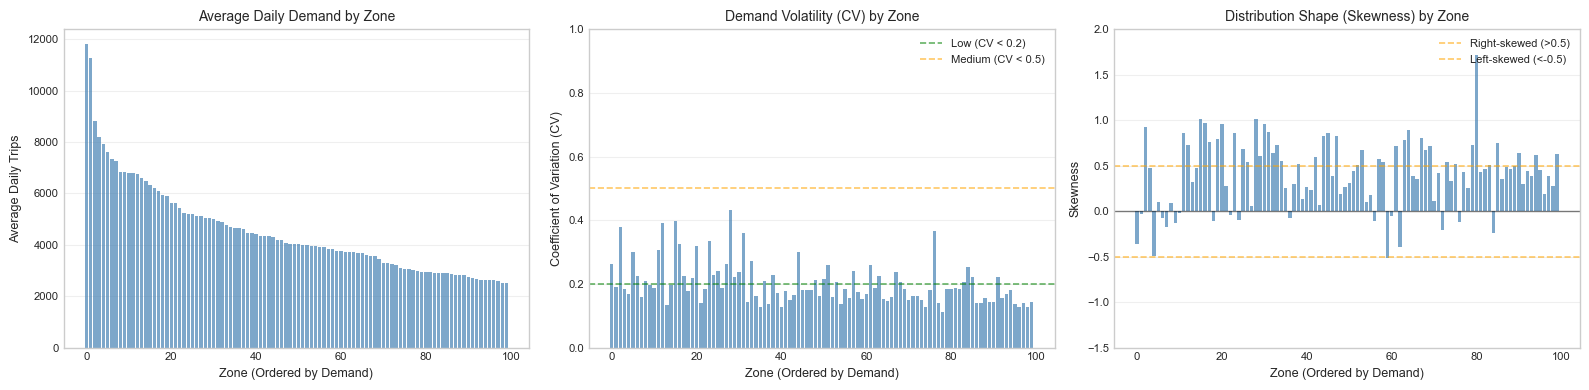

In [21]:
# What: Create three-panel visualization of core zone characteristics
# Why: Visual comparison reveals patterns in volume, stability, and distribution shape

# Sort zones by volume for consistent ordering across all panels
zone_stats_sorted = zone_stats.sort_values('daily_trips_mean', ascending=False)

# Create three-panel layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# LEFT: Average Daily Demand
ax1.bar(range(len(zone_stats_sorted)), zone_stats_sorted['daily_trips_mean'], 
        color='steelblue', alpha=0.7)
ax1.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax1.set_ylabel('Average Daily Trips', fontsize=9)
ax1.set_title('Average Daily Demand by Zone', fontsize=10)
ax1.grid(True, axis='y', alpha=0.3)

# MIDDLE: Coefficient of Variation
ax2.bar(range(len(zone_stats_sorted)), zone_stats_sorted['cv'], 
        color='steelblue', alpha=0.7)
ax2.axhline(y=0.2, color='green', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Low (CV < 0.2)')
ax2.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Medium (CV < 0.5)')
ax2.set_ylim(0, 1.0)
ax2.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax2.set_ylabel('Coefficient of Variation (CV)', fontsize=9)
ax2.set_title('Demand Volatility (CV) by Zone', fontsize=10)
ax2.legend(loc='upper right', fontsize=8, framealpha=0.9)
ax2.grid(True, axis='y', alpha=0.3)

# RIGHT: Skewness
ax3.bar(range(len(zone_stats_sorted)), zone_stats_sorted['skewness'], 
        color='steelblue', alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax3.axhline(y=0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Right-skewed (>0.5)')
ax3.axhline(y=-0.5, color='orange', linestyle='--', linewidth=1.2, alpha=0.6, 
            label='Left-skewed (<-0.5)')
ax3.set_ylim(-1.5, 2.0)
ax3.set_xlabel('Zone (Ordered by Demand)', fontsize=9)
ax3.set_ylabel('Skewness', fontsize=9)
ax3.set_title('Distribution Shape (Skewness) by Zone', fontsize=10)
ax3.legend(loc='upper right', fontsize=8, framealpha=0.9)
ax3.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:** The three panels reveal key zone characteristics. Volume decreases steadily (left), most zones show stable demand with CV < 0.3 (middle), and most zones are symmetric or right-skewed (right) indicating occasional high-demand spikes. These patterns support using robust forecasting methods that handle outliers naturally.

##### 4.4 Save Results

In [22]:
# Save zone statistics
zone_stats.to_csv(OUTPUT_DIR / 'zone_stats_summary.csv', index=False)
print(f"\nSaved zone statistics: {OUTPUT_DIR / 'zone_stats_summary.csv'}")
print(f"  Rows: {len(zone_stats):,}")
print(f"  Columns: {len(zone_stats.columns)}")
print(f"  Metrics: volume, volatility (CV), distribution shape (skewness)")


Saved zone statistics: ..\data\processed\zone_stats_summary.csv
  Rows: 100
  Columns: 12
  Metrics: volume, volatility (CV), distribution shape (skewness)


---

#### 5. Analyze Demand Patterns 
Analyze when demand occurs across multiple time scales: overall trend (3-year), weekly cycles (day-of-week), and seasonal patterns (monthly).

##### 5.1 Visualize Time Based Patterns 

In [23]:
# Create time based pattern visualizations showing demand at multiple time scales

# Daily totals for trend analysis
daily_total = zone_daily.groupby('date')['daily_trips'].sum().reset_index()
daily_total.columns = ['date', 'total_trips']

# Day-of-week patterns
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
dow_avg = zone_daily.groupby('day_name')['daily_trips'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg['day_name'] = pd.Categorical(dow_avg['day_name'], categories=day_order, ordered=True)
dow_avg = dow_avg.sort_values('day_name')

# Monthly patterns
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['month_name'] = zone_daily['date'].dt.month_name()
monthly_avg = zone_daily.groupby('month_name')['daily_trips'].mean().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg['month_name'] = pd.Categorical(monthly_avg['month_name'], 
                                            categories=month_order, ordered=True)
monthly_avg = monthly_avg.sort_values('month_name')

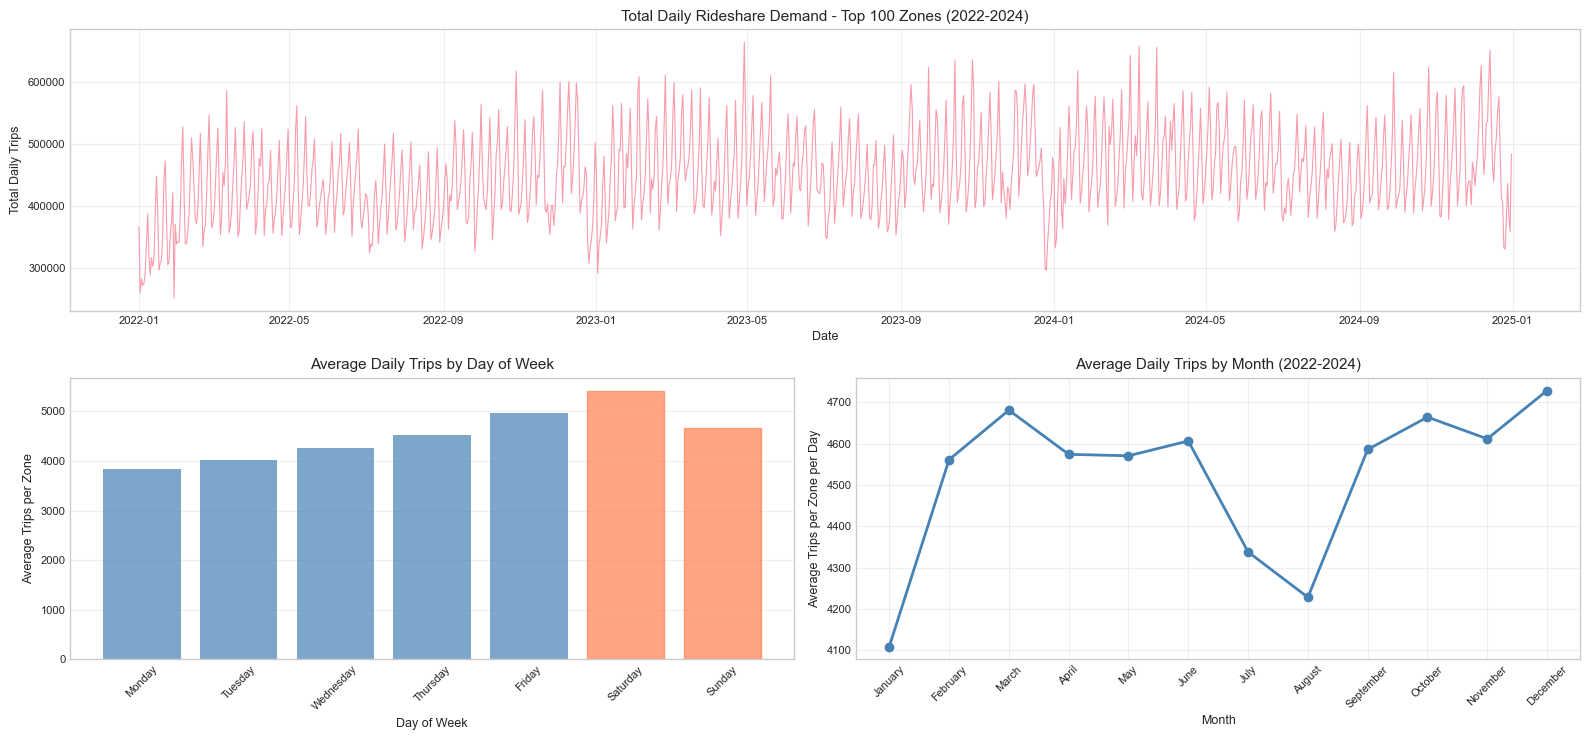

In [24]:
fig = plt.figure(figsize=(16, 7.5))

# TOP ROW: Overall Trend (full width)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(daily_total['date'], daily_total['total_trips'], linewidth=0.8, alpha=0.7)
ax1.set_title(f'Total Daily Rideshare Demand - Top {TOP_N_ZONES} Zones (2022-2024)', fontsize=11)
ax1.set_xlabel('Date', fontsize=9)
ax1.set_ylabel('Total Daily Trips', fontsize=9)
ax1.grid(True, alpha=0.3)

# BOTTOM LEFT: Day-of-Week Patterns
ax2 = fig.add_subplot(2, 2, 3)
bars = ax2.bar(dow_avg['day_name'], dow_avg['daily_trips'], color='steelblue', alpha=0.7)
bars[5].set_color('coral')  # Saturday
bars[6].set_color('coral')  # Sunday
ax2.set_title('Average Daily Trips by Day of Week', fontsize=11)
ax2.set_xlabel('Day of Week', fontsize=9)
ax2.set_ylabel('Average Trips per Zone', fontsize=9)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', alpha=0.3)

# BOTTOM RIGHT: Monthly Patterns
ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(monthly_avg['month_name'], monthly_avg['daily_trips'], marker='o', linewidth=2, color='steelblue')
ax3.set_title('Average Daily Trips by Month (2022-2024)', fontsize=11)
ax3.set_xlabel('Month', fontsize=9)
ax3.set_ylabel('Average Trips per Zone per Day', fontsize=9)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpretation:** Three distinct patterns emerge. The overall trend shows growth through 2022 then stabilization at ~450-550K daily trips. Weekly patterns reveal weekend peaks (Saturday highest) rather than weekday dominance - suggesting leisure/entertainment demand, not just commuter traffic. Monthly patterns show summer lows (July-August) and fall/winter peaks, typical of urban rideshare where holiday travel and weather drive demand.

##### 5.2 Calculate Pattern Statistics

In [25]:
# Calculate summary statistics for seasonal patterns

# Weekly pattern strength
weekday_avg = dow_avg[dow_avg['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['daily_trips'].mean()
weekend_avg = dow_avg[dow_avg['day_name'].isin(['Saturday', 'Sunday'])]['daily_trips'].mean()
weekly_ratio = weekend_avg / weekday_avg

# Seasonal pattern strength
monthly_max = monthly_avg['daily_trips'].max()
monthly_min = monthly_avg['daily_trips'].min()
seasonal_range = ((monthly_max - monthly_min) / monthly_avg['daily_trips'].mean()) * 100

# Overall trend
first_month_avg = daily_total[daily_total['date'] < '2022-02-01']['total_trips'].mean()
last_month_avg = daily_total[daily_total['date'] >= '2024-12-01']['total_trips'].mean()
overall_change = ((last_month_avg - first_month_avg) / first_month_avg) * 100

print("Time Series Pattern Summary:")
print(f"\n  Weekly Pattern:")
print(f"    Weekday average: {weekday_avg:,.0f} trips/zone/day")
print(f"    Weekend average: {weekend_avg:,.0f} trips/zone/day")
print(f"    Weekend/Weekday ratio: {weekly_ratio:.2f}")

print(f"\n  Seasonal Pattern:")
print(f"    Highest month average: {monthly_max:,.0f} trips/zone/day")
print(f"    Lowest month average: {monthly_min:,.0f} trips/zone/day")
print(f"    Seasonal range: {seasonal_range:.1f}% of mean")

print(f"\n  Overall Trend:")
print(f"    Jan 2022 average: {first_month_avg:,.0f} total trips/day")
print(f"    Dec 2024 average: {last_month_avg:,.0f} total trips/day")
print(f"    Change over period: {overall_change:+.1f}%")

Time Series Pattern Summary:

  Weekly Pattern:
    Weekday average: 4,315 trips/zone/day
    Weekend average: 5,034 trips/zone/day
    Weekend/Weekday ratio: 1.17

  Seasonal Pattern:
    Highest month average: 4,728 trips/zone/day
    Lowest month average: 4,110 trips/zone/day
    Seasonal range: 13.7% of mean

  Overall Trend:
    Jan 2022 average: 340,129 total trips/day
    Dec 2024 average: 482,103 total trips/day
    Change over period: +41.7%


**Interpretation:** Weekend/weekday ratio of 1.17 confirms weekend-dominant demand, with weekends averaging 17% higher trips than weekdays. This suggests leisure and entertainment activity drives demand more than commuting. Seasonal range of 13.7% (averaged across 3 years) indicates moderate seasonality with summer lows and fall/winter peaks that models should capture. Overall growth of +41.7% from 2022 to 2024 shows a strong expanding market, important context when interpreting forecast results.

---

#### 6. Measure Zone Correlations
This section examines whether demand patterns are consistent across zones or vary geographically by comparing top zone trends visually then quantifying correlations.

 ##### 6.1 Compare Top Zone Patterns (Visual)

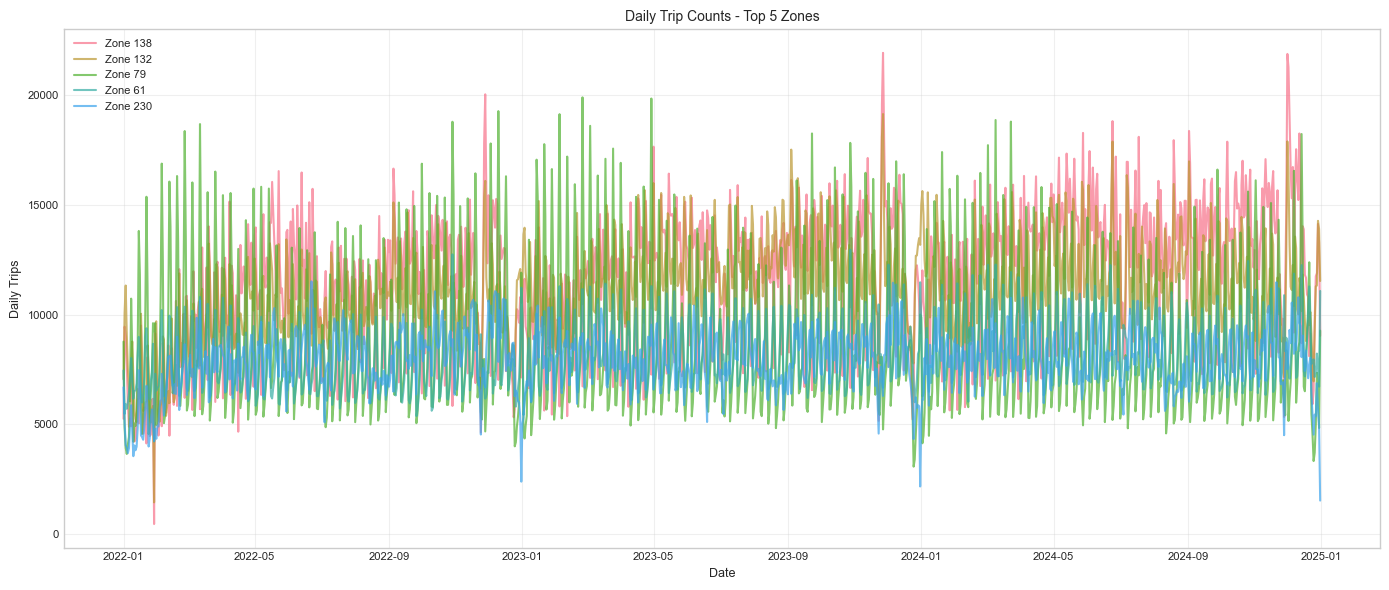

In [26]:
# Select top 5 zones for detailed comparison
top_5_zones = zone_stats.nlargest(5, 'daily_trips_mean')['zone_id'].tolist()

plt.figure(figsize=(14, 6))
for zone_id in top_5_zones:
    zone_ts = zone_daily[zone_daily['zone_id'] == zone_id]
    plt.plot(zone_ts['date'], zone_ts['daily_trips'], label=f'Zone {zone_id}', alpha=0.7)

plt.title('Daily Trip Counts - Top 5 Zones')
plt.xlabel('Date')
plt.ylabel('Daily Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation:** Top 5 zones show visually similar patterns, rising and falling together. Section 6.2 quantifies this similarity across all 100 zones.

 ##### 6.2 Quantify Zone Correlations (Statistical)

In [27]:
# Analyze correlation patterns across zones

# Calculate correlation matrix
zone_pivot = zone_daily.pivot(index='date', columns='zone_id', values='daily_trips')
zone_corr = zone_pivot.corr()

# Extract upper triangle (unique pairs only, exclude diagonal)
import numpy as np
mask = np.triu(np.ones_like(zone_corr, dtype=bool), k=1)
corr_values = zone_corr.where(mask).stack()

# Categorize correlations
high_corr = (corr_values >= 0.7).sum()
medium_corr = ((corr_values >= 0.4) & (corr_values < 0.7)).sum()
low_corr = ((corr_values >= 0) & (corr_values < 0.4)).sum()
negative_corr = (corr_values < 0).sum()
total_pairs = len(corr_values)

print("Zone Correlation Analysis:")
print("=" * 50)
print(f"\nTotal zone pairs analyzed: {total_pairs:,}")
print(f"\nCorrelation Distribution:")
print(f"  High (≥0.7):     {high_corr:,} pairs ({high_corr/total_pairs*100:.1f}%)")
print(f"  Medium (0.4-0.7): {medium_corr:,} pairs ({medium_corr/total_pairs*100:.1f}%)")
print(f"  Low (0-0.4):      {low_corr:,} pairs ({low_corr/total_pairs*100:.1f}%)")
print(f"  Negative (<0):    {negative_corr:,} pairs ({negative_corr/total_pairs*100:.1f}%)")

print(f"\nSummary Statistics:")
print(f"  Mean correlation:   {corr_values.mean():.3f}")
print(f"  Median correlation: {corr_values.median():.3f}")
print(f"  Std deviation:      {corr_values.std():.3f}")

# Identify zones with unusual behavior (low avg correlation with others)
zone_avg_corr = zone_corr.mean()
outlier_zones = zone_avg_corr[zone_avg_corr < zone_avg_corr.quantile(0.1)]

print(f"\nZones with Distinct Patterns (lowest 10% avg correlation):")
for zone_id, avg_corr in outlier_zones.sort_values().head(5).items():
    print(f"  Zone {zone_id}: avg correlation {avg_corr:.3f}")




Zone Correlation Analysis:

Total zone pairs analyzed: 4,950

Correlation Distribution:
  High (≥0.7):     1,988 pairs (40.2%)
  Medium (0.4-0.7): 1,756 pairs (35.5%)
  Low (0-0.4):      824 pairs (16.6%)
  Negative (<0):    382 pairs (7.7%)

Summary Statistics:
  Mean correlation:   0.551
  Median correlation: 0.631
  Std deviation:      0.315

Zones with Distinct Patterns (lowest 10% avg correlation):
  Zone 26: avg correlation -0.203
  Zone 138: avg correlation -0.103
  Zone 132: avg correlation 0.007
  Zone 161: avg correlation 0.029
  Zone 162: avg correlation 0.045


**Interpretation:** Of 4,950 zone pairs, 40% are highly correlated (≥0.7) while 24% show low or negative correlation. Mean correlation of 0.55 suggests a hybrid modeling approach: shared parameters for most zones, individual attention for distinct ones. Zone 26 and Zone 138 show negative correlation with other zones, likely representing unique demand drivers (airports, transit hubs, entertainment districts) worth investigating.

---

#### 7. Detect Outliers

Identify unusual demand days in the aggregated data. Outliers are detected at the daily aggregated level (not raw trips) because forecasting models predict daily demand, not individual trip anomalies. Trip-level data quality issues (invalid durations, negative fares) were addressed in the validation stage.

##### 7.1 Detect Outliers (IQR Method)

While demand levels vary dramatically across zones, the variability *within* each zone over time is low (CV < 0.3). Combined with moderate seasonality (13.7%), this justifies simple IQR detection over complex seasonal decomposition - each zone's demand stays close enough to its own mean that standard statistical bounds work well.

In [28]:
# What: Detect outliers using IQR method
# Why: Low CV and moderate seasonality make simple approach sufficient

Q1 = zone_daily['daily_trips'].quantile(0.25)
Q3 = zone_daily['daily_trips'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

zone_daily['is_outlier'] = (zone_daily['daily_trips'] < lower_bound) | (zone_daily['daily_trips'] > upper_bound)
outliers = zone_daily[zone_daily['is_outlier']]

pct_outliers = len(outliers) / len(zone_daily) * 100

print("OUTLIER DETECTION (IQR Method)")
print("=" * 50)
print(f"Lower bound:  {lower_bound:,.0f} trips")
print(f"Upper bound:  {upper_bound:,.0f} trips")
print(f"Total records: {len(zone_daily):,}")
print(f"Outliers:      {len(outliers):,} ({pct_outliers:.2f}%)")
print(f"  High demand: {(outliers['daily_trips'] > upper_bound).sum():,}")
print(f"  Low demand:  {(outliers['daily_trips'] < lower_bound).sum():,}")

OUTLIER DETECTION (IQR Method)
Lower bound:  -214 trips
Upper bound:  8,579 trips
Total records: 109,600
Outliers:      5,624 (5.13%)
  High demand: 5,624
  Low demand:  0


##### 7.2 Outlier Distribution

In [29]:
# What: Analyze outlier distribution by zone, month, and day of week
# Why: Understand if outliers are concentrated or spread across dimensions

print("OUTLIER DISTRIBUTION")
print("=" * 50)

# By zone
outliers_by_zone = outliers.groupby('zone_id').size().sort_values(ascending=False)
print(f"\nBy Zone (top 5):")
for zone_id, count in outliers_by_zone.head(5).items():
    print(f"  Zone {zone_id}: {count} outliers")

# By month
outliers_by_month = outliers.groupby('month').size().sort_index()
print(f"\nBy Month:")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, count in outliers_by_month.items():
    print(f"  {month_names[month-1]}: {count}")

# By day of week
outliers_by_dow = outliers.groupby('day_name').size()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\nBy Day of Week:")
for day in day_order:
    count = outliers_by_dow.get(day, 0)
    print(f"  {day}: {count}")

OUTLIER DISTRIBUTION

By Zone (top 5):
  Zone 132: 1012 outliers
  Zone 138: 895 outliers
  Zone 79: 456 outliers
  Zone 61: 423 outliers
  Zone 161: 385 outliers

By Month:
  Jan: 353
  Feb: 418
  Mar: 503
  Apr: 462
  May: 476
  Jun: 497
  Jul: 403
  Aug: 340
  Sep: 497
  Oct: 567
  Nov: 498
  Dec: 610

By Day of Week:
  Monday: 333
  Tuesday: 473
  Wednesday: 570
  Thursday: 683
  Friday: 797
  Saturday: 1748
  Sunday: 1020


**Interpretation:** Low outlier percentage confirms data stability. Outliers are detected at the aggregated daily level because forecasting models predict daily demand, not individual trips. Trip-level anomalies were handled during validation.

The choice of simple IQR over seasonal decomposition (STL) reflects a key principle: data characteristics should drive method selection. This dataset's low variability (CV < 0.3) makes simple methods sufficient. Highly variable data with strong seasonal patterns would require decomposing seasonality first.

*Note: This contrasts with highly variable data where segments show vastly different patterns. In such cases, STL decomposition becomes essential for accurate outlier detection.*

**Action:** Outliers are flagged but retained. Right-skewed distributions (Section 4) indicate high-demand days are legitimate spikes, not errors. Tree-based models and Prophet are robust to these values.
```

---

#### 8. Add Time Features

Feature engineering for modeling: add calendar and holiday features. Lag and rolling features created in modeling stage based on model requirements.

In [30]:
# Time-based features
zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6])
zone_daily['season'] = zone_daily['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

# Holiday flag
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2022-01-01', end='2024-12-31')
zone_daily['is_holiday'] = zone_daily['date'].isin(holidays)

print("TIME FEATURES ADDED")
print("=" * 40)
print(f"Features: year, month, day_of_week, is_weekend, season, is_holiday")
print(f"Total columns: {len(zone_daily.columns)}")
print(f"Holiday rows flagged: {zone_daily['is_holiday'].sum():,} ({len(holidays)} holidays × 100 zones)")
zone_daily.head()

TIME FEATURES ADDED
Features: year, month, day_of_week, is_weekend, season, is_holiday
Total columns: 16
Holiday rows flagged: 3,200 (32 holidays × 100 zones)


,date,zone_id,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,year,month,day_of_week,day_name,is_weekend,month_name,is_outlier,season,is_holiday
0,2022-01-01,7,6144,89679.4,14.6,29528.5,4.81,2022,1,5,Saturday,True,January,False,winter,False
1,2022-01-01,13,1505,26165.4,17.4,8352.0,5.55,2022,1,5,Saturday,True,January,False,winter,False
2,2022-01-01,14,2552,36911.7,14.5,14048.4,5.50,2022,1,5,Saturday,True,January,False,winter,False
3,2022-01-01,17,4844,74738.9,15.4,20189.2,4.17,2022,1,5,Saturday,True,January,False,winter,False
4,2022-01-01,18,2797,38208.2,13.7,11795.1,4.22,2022,1,5,Saturday,True,January,False,winter,False


 #### 9. Save Modeling Dataset
 Save prepared datasets for the modeling stage and summarize key findings that will inform forecasting approach.

 ##### 9.1 Save Datasets

In [32]:
# Save feature-enhanced dataset
print("Saving prepared datasets for modeling stage...")

zone_daily.to_parquet(OUTPUT_DIR / 'zone_daily.parquet', index=False)
print(f"  Saved: {OUTPUT_DIR / 'zone_daily.parquet'}")
print(f"    Rows: {len(zone_daily):,}")
print(f"    Columns: {len(zone_daily.columns)}")

print(f"\nOutput files ready for Stage 3 (Modeling)")

Saving prepared datasets for modeling stage...
  Saved: ..\data\processed\zone_daily.parquet
    Rows: 109,600
    Columns: 16

Output files ready for Stage 3 (Modeling)


---

### Conclusion

**Results Summary:**
- Input: 683M trips across 263 zones (2022-2024)
- Output: 109,600 rows (100 zones × 1,096 days)
- Demand coverage: ~72% of total market
- Features: 22 columns including time features and holiday flags

**Key Findings:**
- Weekend-dominant demand (17% higher than weekdays) suggests leisure/entertainment drivers
- Moderate seasonality (13.7% range) with summer lows, fall/winter peaks
- 40% of zone pairs highly correlated - supports shared modeling approach
- Low within-zone variability (CV < 0.3) made simple IQR outlier detection sufficient
- +41.7% demand growth from 2022-2024 indicates expanding market

**Zone Selection:** Top 100 zones capture ~72% of demand. NYC's distributed pattern (vs typical 80%+ Pareto) reflects TLC zone design balancing coverage with model feasibility.

**Output Files:**
- `zone_daily.parquet` - Ready for modeling
- `zone_metadata.csv` - Zone metadata

**Next:** Stage 3 (Modeling) - STL decomposition, Prophet, and XGBoost forecasting

---

### Future Work & Limitations

**Future Work:**
- Weather and event data integration
- Trip length segmentation (short/medium/long)
- Origin-destination flow analysis
- Low-volume zone analysis

**Limitations:**
- Zones with incomplete 36-month coverage excluded
- HVFHS only (excludes yellow/green taxi)
- Major events not explicitly modeled (deferred to Prophet)
```

---

To do create a data set with all the records to be used for kaggle